In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [3]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Data Pre-processing

In [4]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [6]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [7]:
model = FCNN(config=config)
model

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

# Case 1: No Normalization

In [8]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32)

Training set size: 510
Validation set size: 109
Testing set size: 111


In [8]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_noNorm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 4.450e+01, Val Loss: 5.710e+01, Epoch Time: 292.56s
Model saved at epoch 1
Epoch 2, Train Loss: 4.001e+01, Val Loss: 1.342e+04, Epoch Time: 290.85s
Model saved at epoch 2
Epoch 3, Train Loss: 3.846e+01, Val Loss: 5.345e+04, Epoch Time: 290.64s
Model saved at epoch 3
Epoch 4, Train Loss: 3.661e+01, Val Loss: 3.801e+05, Epoch Time: 290.30s
Model saved at epoch 4
Epoch 5, Train Loss: 3.533e+01, Val Loss: 2.392e+06, Epoch Time: 289.44s
Model saved at epoch 5
Epoch 6, Train Loss: 3.438e+01, Val Loss: 7.825e+02, Epoch Time: 291.24s
Model saved at epoch 6
Epoch 7, Train Loss: 3.241e+01, Val Loss: 1.820e+02, Epoch Time: 291.04s
Model saved at epoch 7
Epoch 8, Train Loss: 3.118e+01, Val Loss: 2.576e+03, Epoch Time: 290.80s
Model saved at epoch 8
Epoch 9, Train Loss: 3.139e+01, Val Loss: 4.065e+02, Epoch Time: 293.62s
Model saved at epoch 9
Epoch 10, Train Loss: 2.936e+01, Val Loss: 7.690e+02, Epoch Time: 293.07s
Model saved at epoch 10
Epoch 11,

In [9]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_noNorm.pth')
sgs_pred

Loaded model parameters from ./model_noNorm.pth


array([[[-11.369167 , -11.3598   , -11.335302 , ...,  -9.680869 ,
          -9.69653  ,  -9.704983 ],
        [-11.355075 , -11.34573  , -11.321516 , ...,  -9.737177 ,
          -9.752774 ,  -9.761205 ],
        [-11.317701 , -11.308562 , -11.285126 , ...,  -9.877307 ,
          -9.892765 ,  -9.901126 ],
        ...,
        [ -2.5809853,  -2.5974505,  -2.6354234, ...,   2.8714063,
           2.8136811,   2.7821553],
        [ -2.561633 ,  -2.5781019,  -2.616098 , ...,   2.8547344,
           2.796488 ,   2.7647264],
        [ -2.554198 ,  -2.5706687,  -2.6086764, ...,   2.8484   ,
           2.7899966,   2.7581556]],

       [[-11.156936 , -11.153775 , -11.138678 , ...,  -7.919629 ,
          -7.9536686,  -7.9715514],
        [-11.190228 , -11.187048 , -11.171744 , ...,  -7.938516 ,
          -7.972731 ,  -7.990688 ],
        [-11.27121  , -11.267886 , -11.252029 , ...,  -7.9837327,
          -8.018354 ,  -8.03651  ],
        ...,
        [ -2.7382512,  -2.740389 ,  -2.7411287, ...,  

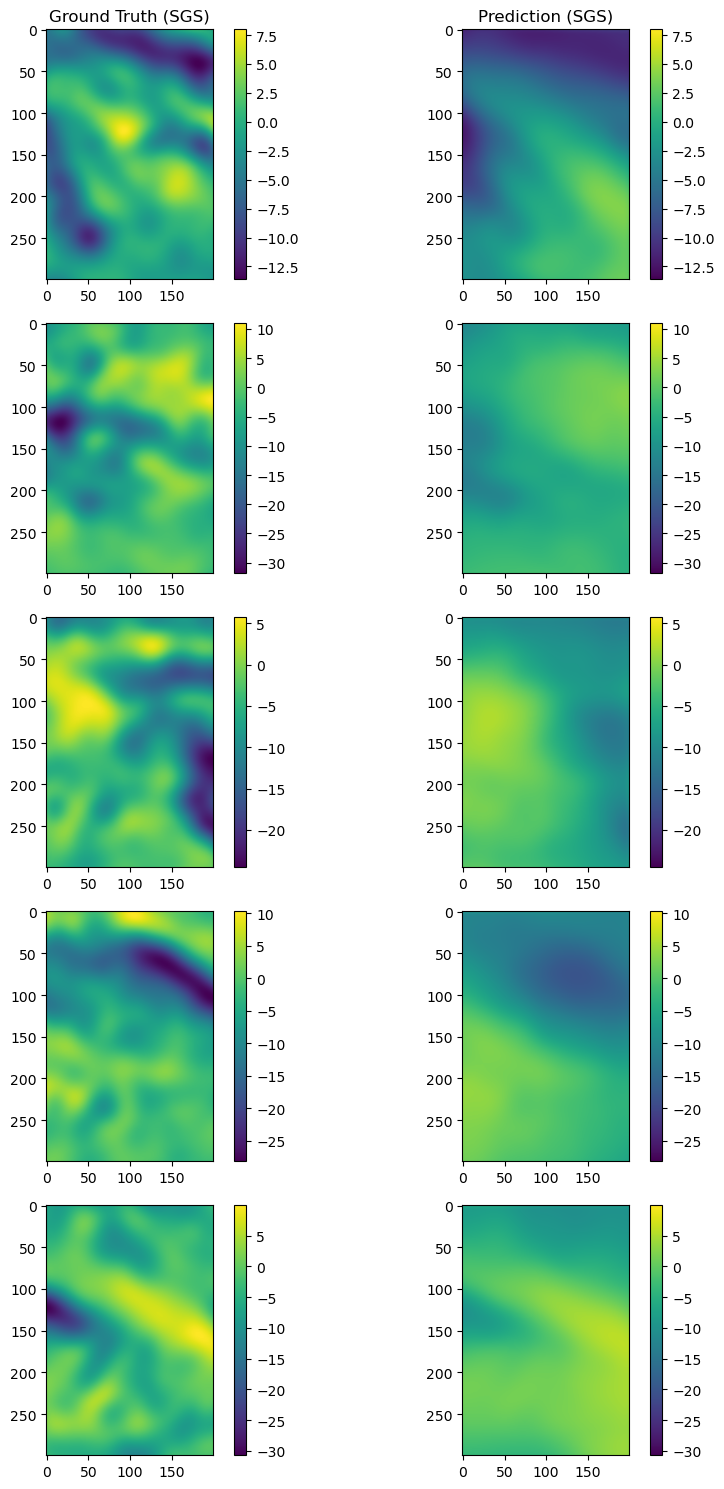

In [10]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

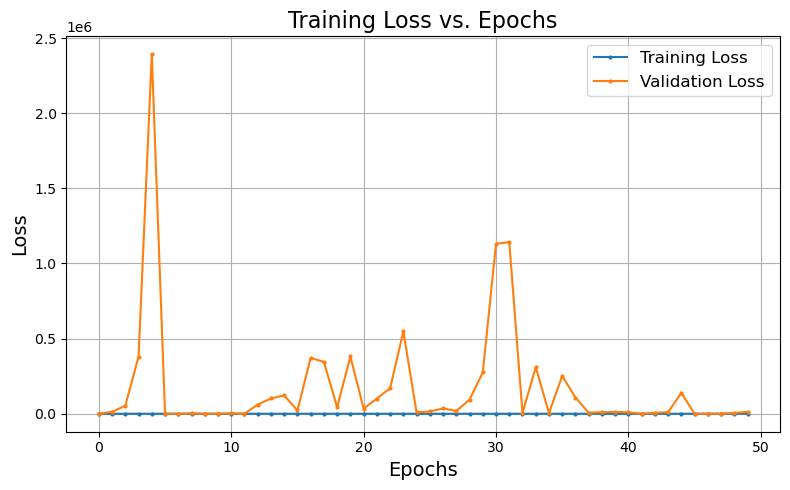

In [11]:
plot_train_val_losses(train_losses, val_losses)

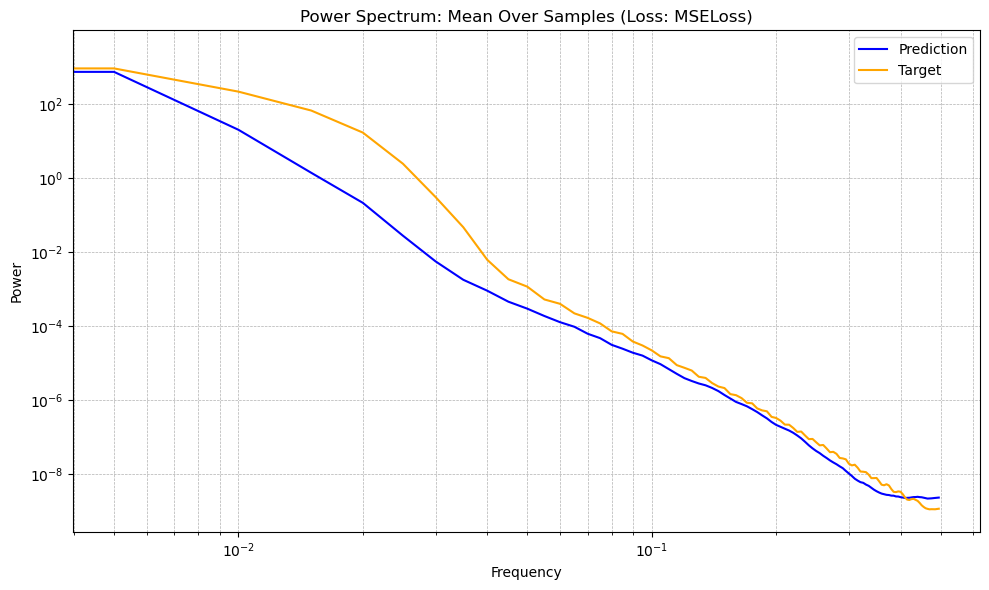

In [12]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

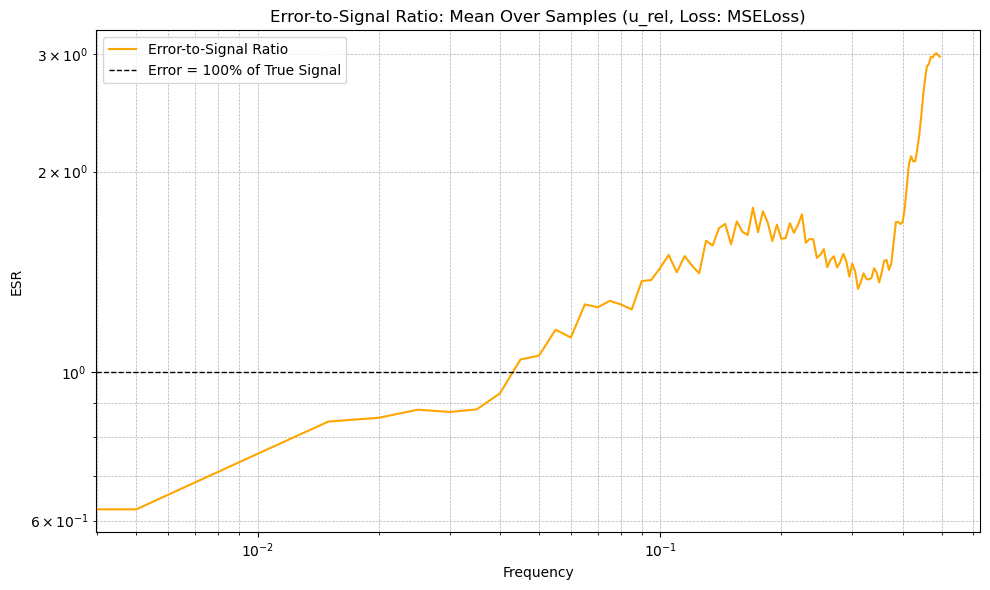

In [13]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [14]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 0.5
MSE is 36.959590911865234
Pearson correlation coefficient is 0.598784769229816
r2 is 0.13906168937683105
ESR first exceeds half at None


# Case 2: Normalization

In [11]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [ ]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

In [ ]:
train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_normalized.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 1.540e+01, Val Loss: 1.174e+03, Epoch Time: 279.12s
Model saved at epoch 1
Epoch 2, Train Loss: 7.358e+00, Val Loss: 1.043e+00, Epoch Time: 278.45s
Model saved at epoch 2
Epoch 3, Train Loss: 4.608e+00, Val Loss: 2.033e+00, Epoch Time: 277.34s
Model saved at epoch 3
Epoch 4, Train Loss: 2.976e+00, Val Loss: 2.026e+00, Epoch Time: 279.06s
Model saved at epoch 4
Epoch 5, Train Loss: 1.969e+00, Val Loss: 1.527e+00, Epoch Time: 278.48s
Model saved at epoch 5
Epoch 6, Train Loss: 1.322e+00, Val Loss: 1.033e+00, Epoch Time: 277.75s
Model saved at epoch 6
Epoch 7, Train Loss: 8.919e-01, Val Loss: 6.831e-01, Epoch Time: 279.76s
Model saved at epoch 7
Epoch 8, Train Loss: 5.962e-01, Val Loss: 4.480e-01, Epoch Time: 281.38s
Model saved at epoch 8
Epoch 9, Train Loss: 3.857e-01, Val Loss: 2.855e-01, Epoch Time: 281.25s
Model saved at epoch 9
Epoch 10, Train Loss: 2.375e-01, Val Loss: 1.709e-01, Epoch Time: 281.12s
Model saved at epoch 10
Epoch 11,

In [12]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_normalized.pth')
sgs_pred

Loaded model parameters from ./model_normalized.pth


array([[[0.6232716 , 0.62295365, 0.6225992 , ..., 0.74971014,
         0.74784815, 0.74394417],
        [0.62450427, 0.6242084 , 0.6238344 , ..., 0.75179875,
         0.74990946, 0.74600244],
        [0.6268895 , 0.6265868 , 0.6262301 , ..., 0.7506652 ,
         0.7488331 , 0.7449192 ],
        ...,
        [0.72245556, 0.722826  , 0.72347265, ..., 0.73738956,
         0.73646843, 0.73635626],
        [0.7228223 , 0.7231641 , 0.7236907 , ..., 0.73222876,
         0.73116636, 0.7310406 ],
        [0.7227468 , 0.7230761 , 0.7235699 , ..., 0.72872925,
         0.7276263 , 0.72749496]],

       [[0.71239346, 0.7119536 , 0.71115464, ..., 0.6288869 ,
         0.6278169 , 0.6269947 ],
        [0.7121502 , 0.71164864, 0.71076477, ..., 0.6274164 ,
         0.62634295, 0.6255129 ],
        [0.7128957 , 0.71240765, 0.7115737 , ..., 0.6241678 ,
         0.6230836 , 0.6222367 ],
        ...,
        [0.7636681 , 0.76318246, 0.76248527, ..., 0.75886554,
         0.7594969 , 0.7596538 ],
        [0.7

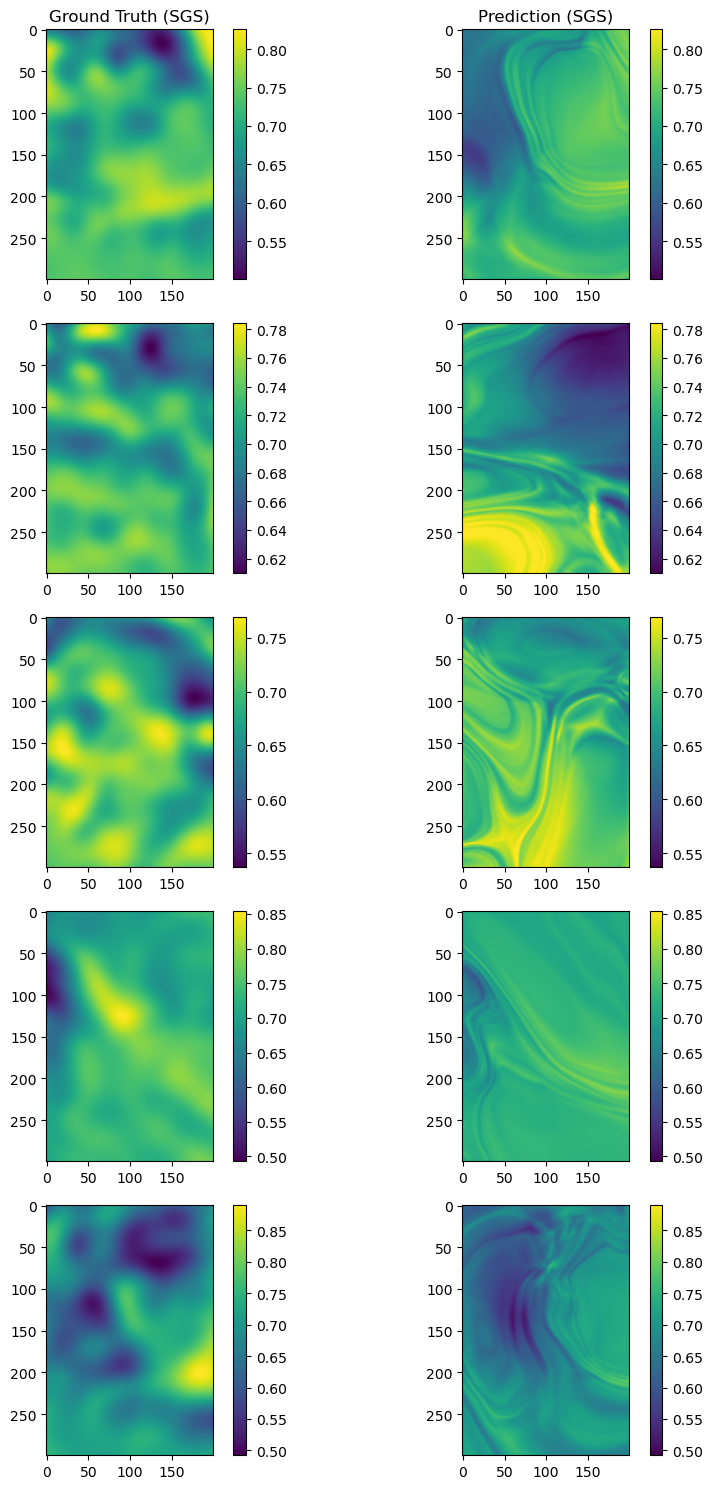

In [13]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

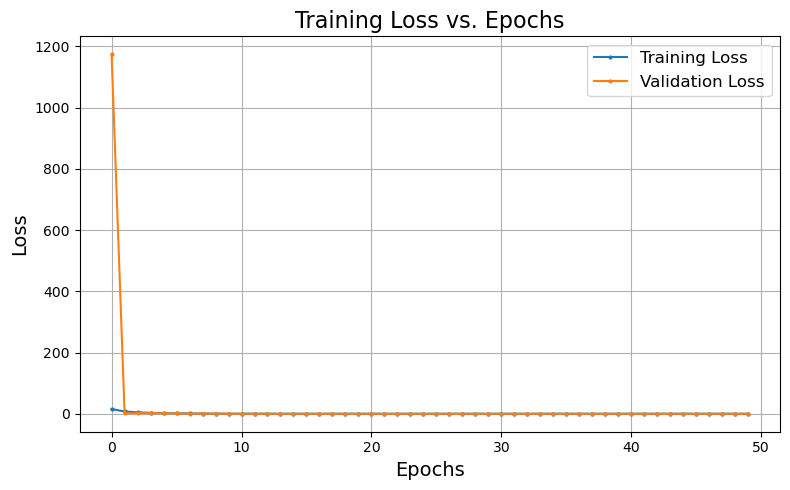

In [ ]:
plot_train_val_losses(train_losses, val_losses)

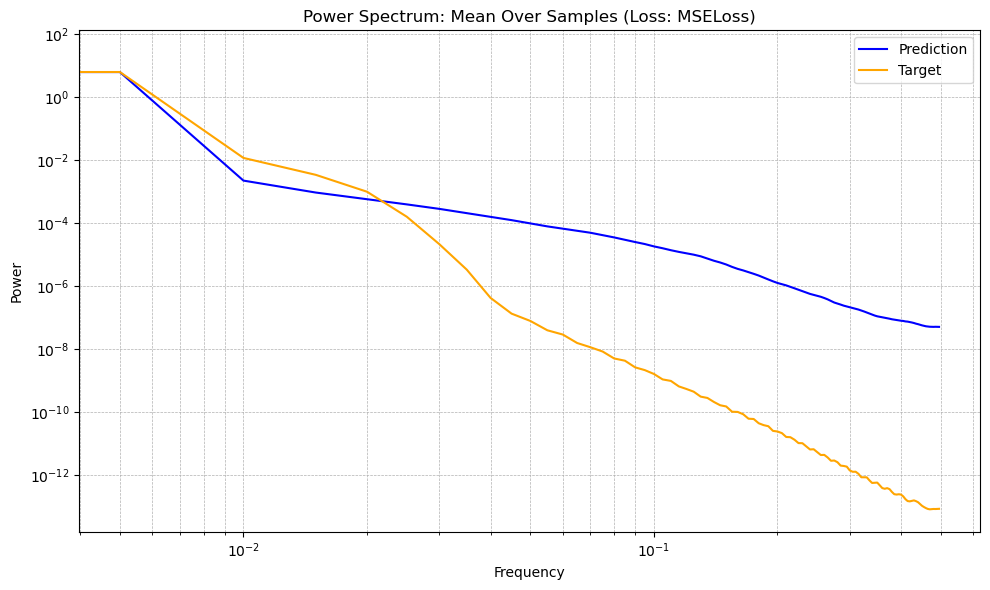

In [ ]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

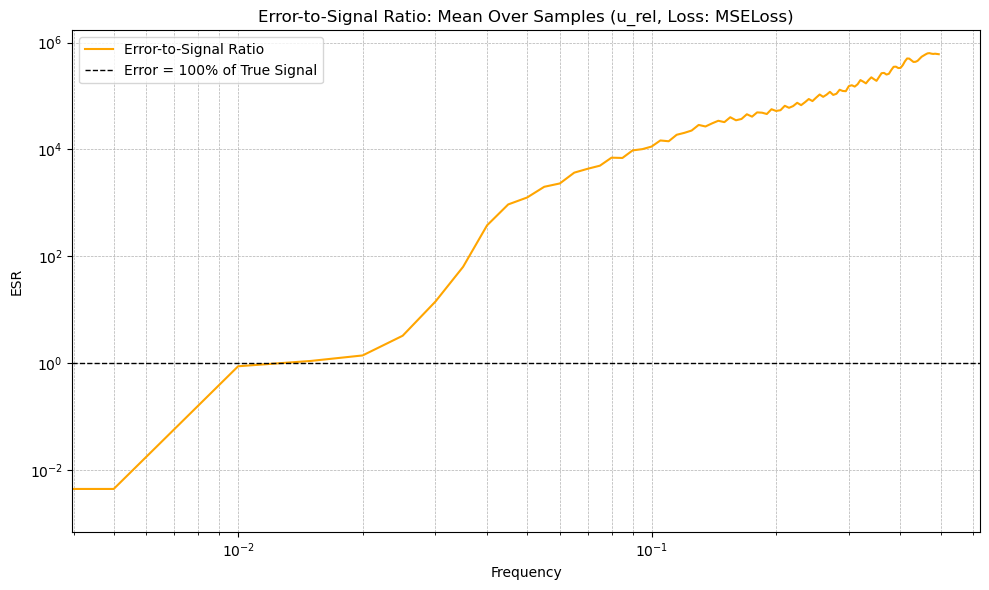

In [ ]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [ ]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 0.5
MSE is 0.0018521695164963603
Pearson correlation coefficient is 0.5962824979176164
r2 is 0.3546561002731323
ESR first exceeds half at None


# Case 3: Standardization

In [14]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [ ]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_standardized.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 9.296e-01, Val Loss: 6.682e-01, Epoch Time: 280.12s
Model saved at epoch 1
Epoch 2, Train Loss: 5.788e-01, Val Loss: 5.320e-01, Epoch Time: 281.67s
Model saved at epoch 2
Epoch 3, Train Loss: 5.449e-01, Val Loss: 5.252e-01, Epoch Time: 283.77s
Model saved at epoch 3
Epoch 4, Train Loss: 5.324e-01, Val Loss: 4.983e-01, Epoch Time: 283.22s
Model saved at epoch 4
Epoch 5, Train Loss: 5.099e-01, Val Loss: 4.905e-01, Epoch Time: 283.81s
Model saved at epoch 5
Epoch 6, Train Loss: 4.996e-01, Val Loss: 4.652e-01, Epoch Time: 286.77s
Model saved at epoch 6
Epoch 7, Train Loss: 5.175e-01, Val Loss: 4.845e-01, Epoch Time: 282.99s
Model saved at epoch 7
Epoch 8, Train Loss: 5.146e-01, Val Loss: 5.562e-01, Epoch Time: 282.40s
Model saved at epoch 8
Epoch 9, Train Loss: 5.042e-01, Val Loss: 4.759e-01, Epoch Time: 280.54s
Model saved at epoch 9
Epoch 10, Train Loss: 4.823e-01, Val Loss: 4.509e-01, Epoch Time: 279.99s
Model saved at epoch 10
Epoch 11,

In [15]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_standardized.pth')
sgs_pred

Loaded model parameters from ./model_standardized.pth


array([[[-1.1275908 , -1.1278201 , -1.1302165 , ..., -0.45261875,
         -0.43645445, -0.42781863],
        [-1.1265243 , -1.1266985 , -1.1290606 , ..., -0.44667998,
         -0.42739278, -0.41839707],
        [-1.1217315 , -1.1217664 , -1.1240368 , ..., -0.4466447 ,
         -0.4235251 , -0.41196993],
        ...,
        [ 0.780433  ,  0.7821208 ,  0.784681  , ...,  0.4656916 ,
          0.45146063,  0.42988807],
        [ 0.7865188 ,  0.7882305 ,  0.7908838 , ...,  0.4084374 ,
          0.39759198,  0.37919396],
        [ 0.7891695 ,  0.79088604,  0.79356295, ...,  0.37729073,
          0.36791855,  0.35006922]],

       [[-0.5742246 , -0.5743274 , -0.5748143 , ..., -0.5156809 ,
         -0.52341825, -0.5254334 ],
        [-0.5788046 , -0.57891375, -0.5793533 , ..., -0.5179781 ,
         -0.5258628 , -0.52812517],
        [-0.5967253 , -0.5968477 , -0.59707314, ..., -0.52135855,
         -0.5296989 , -0.5323489 ],
        ...,
        [ 0.21061979,  0.21028195,  0.20995393, ...,  

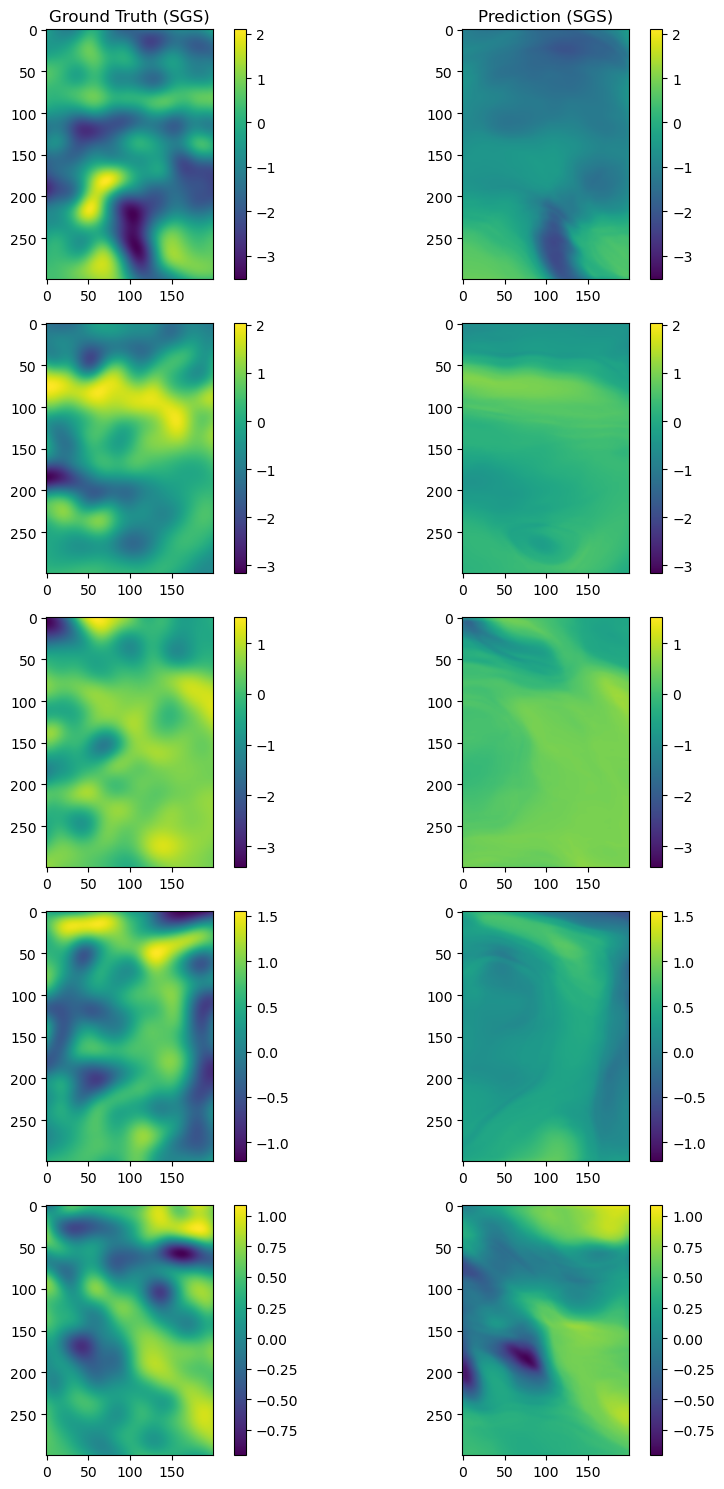

In [18]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

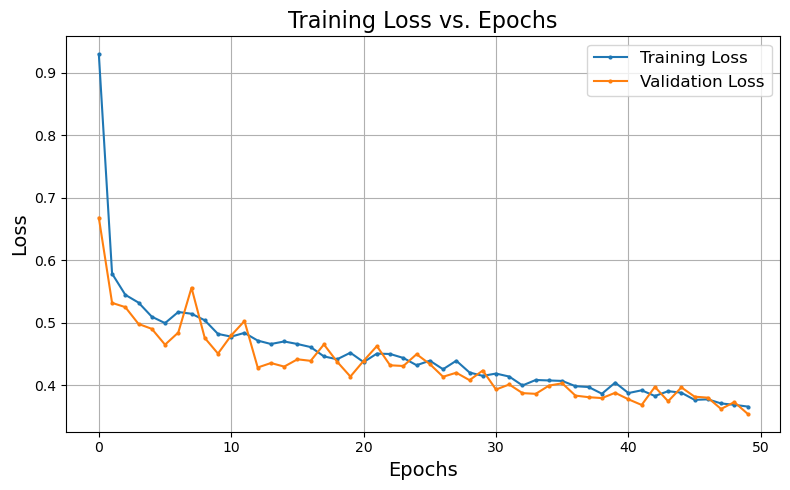

In [ ]:
plot_train_val_losses(train_losses, val_losses)

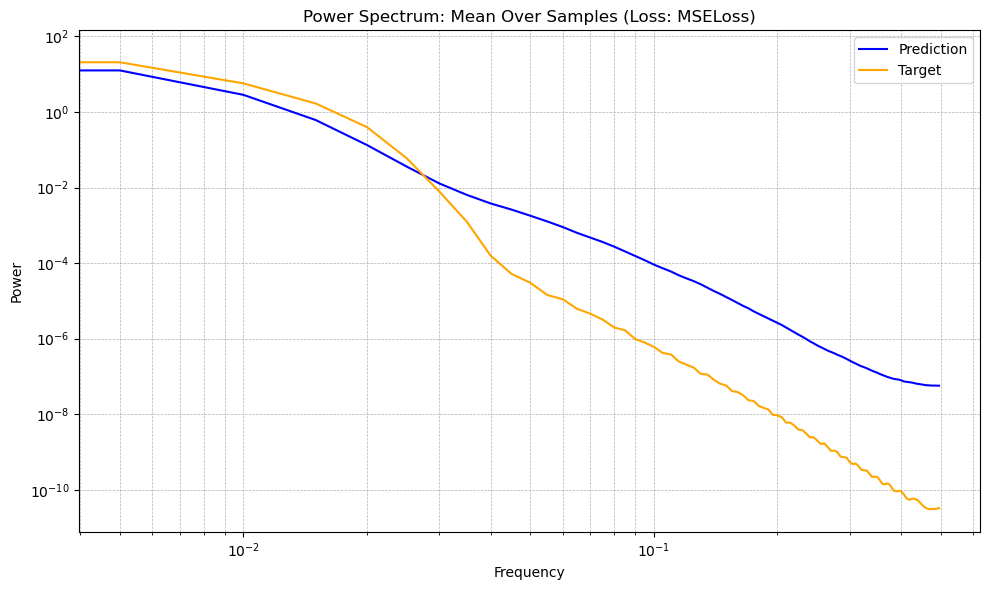

In [ ]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

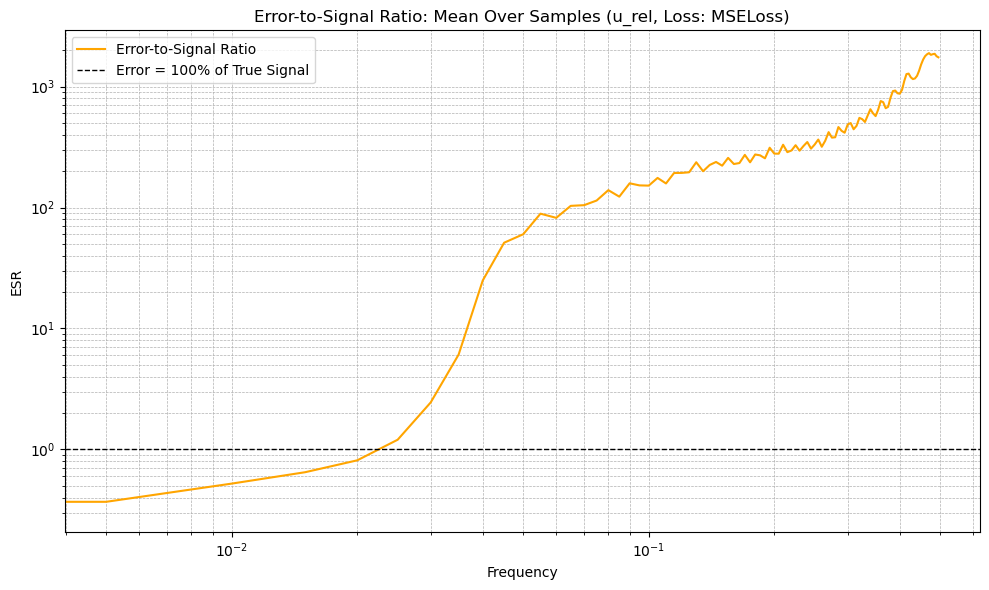

In [ ]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [ ]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 0.5
MSE is 0.46875855326652527
Pearson correlation coefficient is 0.7703022643446833
r2 is 0.5921870470046997
ESR first exceeds half at None
